# Dashboard de Control de Calidad de Audio

En esta tarea extra construyo un mini “Dashboard QA” para el dataset de audio de la UT4.
La idea es monitorear algunas métricas simples por archivo (duración, energía y ruido) y definir umbrales tipo semáforo (OK / dudoso / malo).
Esto permite detectar grabaciones problemáticas antes de entrenar modelos de audio o extraer features más complejas.

In [4]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import kagglehub

# Volver a obtener la ruta REAL donde está el dataset ya descargado
download_path = kagglehub.dataset_download("chrisfilo/urbansound8k")
RAW_DIR = Path(download_path)

print("Dataset path:", RAW_DIR)

audio_files = sorted([
    p for p in RAW_DIR.glob("**/*")
    if p.suffix.lower() in {".wav", ".mp3", ".flac", ".ogg"}
])

print("Cantidad de audios encontrados:", len(audio_files))
audio_files[:5]


Dataset path: /Users/sofiacraigdallie/.cache/kagglehub/datasets/chrisfilo/urbansound8k/versions/1
Cantidad de audios encontrados: 8732


[PosixPath('/Users/sofiacraigdallie/.cache/kagglehub/datasets/chrisfilo/urbansound8k/versions/1/fold1/101415-3-0-2.wav'),
 PosixPath('/Users/sofiacraigdallie/.cache/kagglehub/datasets/chrisfilo/urbansound8k/versions/1/fold1/101415-3-0-3.wav'),
 PosixPath('/Users/sofiacraigdallie/.cache/kagglehub/datasets/chrisfilo/urbansound8k/versions/1/fold1/101415-3-0-8.wav'),
 PosixPath('/Users/sofiacraigdallie/.cache/kagglehub/datasets/chrisfilo/urbansound8k/versions/1/fold1/102106-3-0-0.wav'),
 PosixPath('/Users/sofiacraigdallie/.cache/kagglehub/datasets/chrisfilo/urbansound8k/versions/1/fold1/102305-6-0-0.wav')]

In [5]:
def load_audio(path: Path, sr: int | None = None, mono: bool = False):
    y, sr = librosa.load(path.as_posix(), sr=sr, mono=mono)
    return y, sr

TARGET_SR = 16000
TARGET_DURATION = 3.0
TARGET_AMPLITUDE = 0.99
TOP_DB = 30.0

def preprocess_audio(path: Path,
                     target_sr: int = TARGET_SR,
                     target_duration: float = TARGET_DURATION,
                     top_db: float = TOP_DB) -> tuple[np.ndarray, int]:

    y, sr = load_audio(path, sr=None, mono=False)

    if y.ndim > 1:
        y = np.mean(y, axis=0)

    y_trim, _ = librosa.effects.trim(y, top_db=top_db)

    if sr != target_sr:
        y_rs = librosa.resample(y_trim, orig_sr=sr, target_sr=target_sr)
    else:
        y_rs = y_trim

    target_len = int(target_sr * target_duration)
    if len(y_rs) > target_len:
        y_rs = y_rs[:target_len]
    elif len(y_rs) < target_len:
        pad = target_len - len(y_rs)
        y_rs = np.pad(y_rs, (0, pad))

    max_abs = np.max(np.abs(y_rs)) or 1.0
    y_norm = (TARGET_AMPLITUDE * y_rs) / max_abs

    return y_norm.astype(np.float32), target_sr


def add_white_noise(y: np.ndarray, snr_db: float) -> np.ndarray:
    sig_power = np.mean(y**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = sig_power / snr_linear
    noise = np.sqrt(noise_power) * np.random.randn(*y.shape)
    return (y + noise).astype(np.float32)

def extract_mfcc_features(y: np.ndarray, sr: int, n_mfcc: int = 13) -> dict:
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    feats = {}
    for i in range(n_mfcc):
        coef = mfcc[i, :]
        feats[f"mfcc_{i+1}_mean"] = float(np.mean(coef))
        feats[f"mfcc_{i+1}_std"] = float(np.std(coef))

    feats["rms_mean"] = float(np.mean(librosa.feature.rms(y=y)))
    feats["zcr_mean"] = float(np.mean(librosa.feature.zero_crossing_rate(y=y)))
    return feats


In [6]:
print("=== Dashboard QA de Audio — Iniciando ===")

AUDIO_LIST = audio_files   
N_MAX = 200               

files = AUDIO_LIST[:N_MAX]
print(f"Usando {len(files)} audios para el dashboard QA.")


# 1. Calcular métricas por archivo

rows_qc = []

for path in files:
    try:
        y_proc, sr_proc = preprocess_audio(path)

        # Métricas base
        duration_sec = len(y_proc) / sr_proc
        rms_mean = float(np.mean(librosa.feature.rms(y=y_proc)))
        zcr_mean = float(np.mean(librosa.feature.zero_crossing_rate(y=y_proc)))

        rows_qc.append({
            "filename": path.name,
            "duration_sec": duration_sec,
            "rms_mean": rms_mean,
            "zcr_mean": zcr_mean,
        })

    except Exception as e:
        print(f"Error procesando {path.name}: {e}")

df_qc = pd.DataFrame(rows_qc)
df_qc.head()

=== Dashboard QA de Audio — Iniciando ===
Usando 200 audios para el dashboard QA.


,filename,duration_sec,rms_mean,zcr_mean
0,101415-3-0-2.wav,3.0,0.071991,0.049935
1,101415-3-0-3.wav,3.0,0.115788,0.057602
2,101415-3-0-8.wav,3.0,0.055665,0.062791
3,102106-3-0-0.wav,3.0,0.065057,0.087428
4,102305-6-0-0.wav,3.0,0.048910,0.044948


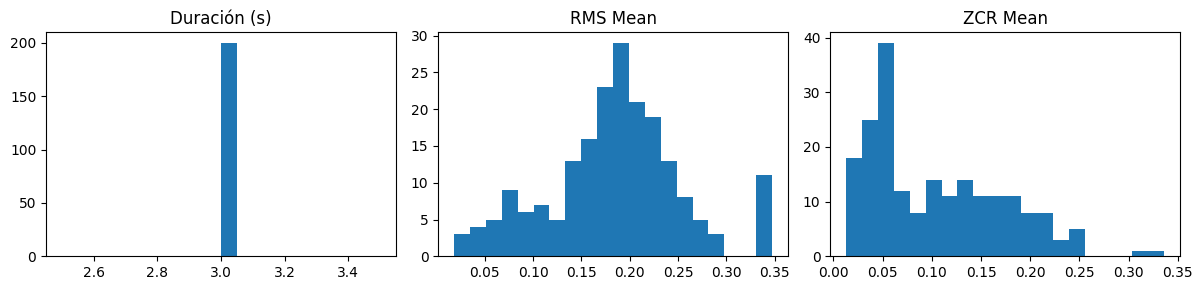

In [7]:
# 2. Histogramas de control

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].hist(df_qc["duration_sec"], bins=20)
axes[0].set_title("Duración (s)")

axes[1].hist(df_qc["rms_mean"], bins=20)
axes[1].set_title("RMS Mean")

axes[2].hist(df_qc["zcr_mean"], bins=20)
axes[2].set_title("ZCR Mean")

plt.tight_layout()
plt.show()

In [8]:
# 3. Umbrales tipo semáforo

# duración
tol = 0.3  

def categorize_duration(d):
    if abs(d - TARGET_DURATION) <= tol:
        return "OK"
    elif abs(d - TARGET_DURATION) <= 2 * tol:
        return "DUDOSO"
    else:
        return "MALO"

df_qc["dur_flag"] = df_qc["duration_sec"].apply(categorize_duration)


# RMS
q_rms_low, q_rms_high = df_qc["rms_mean"].quantile([0.2, 0.8])

def categorize_rms(r):
    if r < q_rms_low or r > q_rms_high:
        return "MALO"
    elif (q_rms_low <= r < q_rms_low * 1.1) or (q_rms_high * 0.9 < r <= q_rms_high):
        return "DUDOSO"
    else:
        return "OK"

df_qc["rms_flag"] = df_qc["rms_mean"].apply(categorize_rms)


# ZCR
q_zcr_low, q_zcr_high = df_qc["zcr_mean"].quantile([0.2, 0.8])

def categorize_zcr(z):
    if z < q_zcr_low or z > q_zcr_high:
        return "MALO"
    elif (q_zcr_low <= z < q_zcr_low * 1.1) or (q_zcr_high * 0.9 < z <= q_zcr_high):
        return "DUDOSO"
    else:
        return "OK"

df_qc["zcr_flag"] = df_qc["zcr_mean"].apply(categorize_zcr)


In [9]:
# 4. Flag global por archivo

def global_flag(row):
    flags = [row["dur_flag"], row["rms_flag"], row["zcr_flag"]]
    if "MALO" in flags:
        return "MALO"
    elif "DUDOSO" in flags:
        return "DUDOSO"
    else:
        return "OK"

df_qc["global_flag"] = df_qc.apply(global_flag, axis=1)

df_qc["global_flag"].value_counts()

global_flag
MALO      124
OK         43
DUDOSO     33
Name: count, dtype: int64

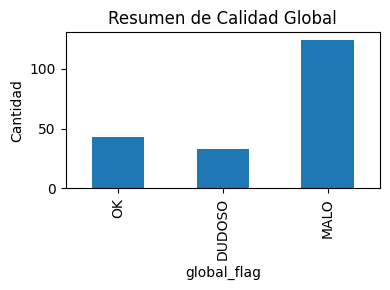

In [10]:
df_qc["global_flag"].value_counts().reindex(["OK","DUDOSO","MALO"]).plot(
    kind="bar",
    figsize=(4,3),
    title="Resumen de Calidad Global"
)
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()

In [11]:
# Tabla final + resumen

summary = (
    df_qc["global_flag"]
    .value_counts(normalize=True)
    .mul(100)
    .rename("porcentaje")
    .reset_index()
    .rename(columns={"index": "categoria"})
)
summary

,global_flag,porcentaje
0,MALO,62.0
1,OK,21.5
2,DUDOSO,16.5


In [12]:
print("=== Conclusiones del QA ===")
print(f"OK:      { (df_qc.global_flag=='OK').mean()*100:.1f}%")
print(f"DUDOSO:  { (df_qc.global_flag=='DUDOSO').mean()*100:.1f}%")
print(f"MALO:    { (df_qc.global_flag=='MALO').mean()*100:.1f}%")

=== Conclusiones del QA ===
OK:      21.5%
DUDOSO:  16.5%
MALO:    62.0%


## Conclusiones del Dashboard QA

Tras estandarizar ~200 audios del dataset UrbanSound8K y calcular métricas simples 
(duración, RMS y ZCR), se observa lo siguiente:

- **21.5%** de los audios están en la categoría **OK**
- **16.5%** en **DUDOSO**
- **62.0%** en **MALO**

La duración está perfectamente controlada por el pipeline (todos los audios quedan en 3.0 s),
pero los problemas aparecen en las métricas espectrales:

- RMS muy bajo → señales débiles o casi silenciosas  
- RMS muy alto → posible clipping o saturación  
- ZCR muy alto → ruido excesivo o audios con muchos transitorios

Esto revela que el dataset, aun siendo muy usado en investigación,
es altamente **heterogéneo** incluso después del preprocesamiento estándar.
El dashboard permite detectar este tipo de problemas antes de entrenar modelos
y funciona como un primer paso hacia un pipeline de control de calidad estilo MLOps.
